# Clusterização do banco de dados Iris

Autores: Natanael Junior (natmourajr@lps.ufrj.br), Vinicius Mello (viniciusdsmello@poli.ufrj.br) e Pedro Lisboa (pedrohblisboa@gmail.com)

LPS - Laboratório de Processamento de Sinais
<center><img src="../data/logo_lps.jpg"></center>

In [1]:
%time
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Wall time: 0 ns


In [2]:
%time
df = pd.read_csv('../data/iris.csv')

Wall time: 0 ns


In [3]:
trgt = df['target']
#data = df.drop(['target'],axis = 1,inplace = True)
chosen_columns = ['sepal_length','sepal_width','petal_length','petal_width']
data = pd.DataFrame(df, columns = chosen_columns)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_fin(data, predictions, cluster_centers):
    # compute Fi
    n_clusters = np.unique(predictions).shape[0]
    #print(n_clusters)
    class_labels  = np.unique(predictions)
    Fi = np.zeros([n_clusters,1])
    
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fi[icluster] = np.sum((data_norm[predictions==class_labels[icluster]] - 
                              cluster_centers[icluster])**2)
    Fin = np.sum(Fi)
    return Fin, Fi

def calculate_fout(data, predictions, cluster_centers):
    # compute center
    bari = np.mean(data,axis=0)
    n_clusters = np.unique(predictions).shape[0]
    class_labels  = np.unique(predictions)
    Fout = 0
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fout = Fout + np.sum((cluster_centers[icluster]-bari)**2)
    
    return Fout

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

nfolds = 10
foldshandler = StratifiedKFold(n_splits=nfolds)

nclusters = list(range(1,50))
Fin = np.zeros([len(nclusters),nfolds])
Fout= np.zeros_like(Fin)


for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt)):
    if ifold != 0: continue
    #print(ifold,trainId, testId)
    data_scaler = StandardScaler().fit(data.values[trainId])
    data_norm = data_scaler.transform(data)
    
    for icluster in nclusters:
        kmeans = KMeans(n_clusters=icluster, random_state=0).fit(data_norm)
    
        predictions = kmeans.predict(data_norm)
        cluster_centers = kmeans.cluster_centers_
        Fin[icluster-1, ifold], Fi = calculate_fin(data_norm, predictions, cluster_centers)
        Fout[icluster-1, ifold] = calculate_fout(data_norm, predictions, cluster_centers)

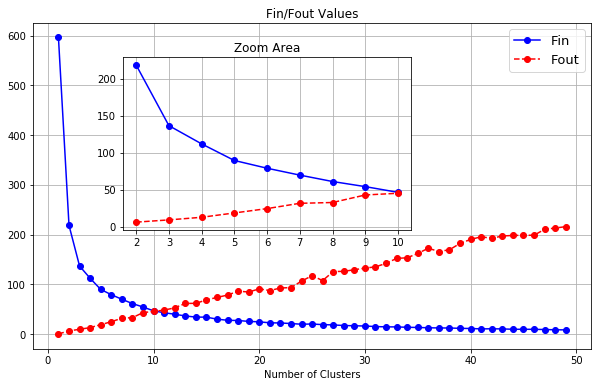

In [6]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)

ax.plot(nclusters,Fin[:,0],'o-',color='blue', label='Fin')
ax.plot(nclusters,Fout[:,0],'o--',color='red', label='Fout')
ax.grid()
ax.set_title('Fin/Fout Analysis')
ax.set_xlabel('Number of Clusters')
ax.set_title('Fin/Fout Values')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='best', fontsize=13,  markerscale=1., scatterpoints=1,)
rect = [0.2,0.2,0.7,0.7]
ax1 = plt.axes([.25, .4, .4, .4], facecolor='w')
ax1.plot(nclusters[1:10],Fin[1:10,0],'o-',color='blue', label='Fin')
ax1.plot(nclusters[1:10],Fout[1:10,0],'o--',color='red', label='Fout')
ax1.grid()
ax1.set_title('Zoom Area');


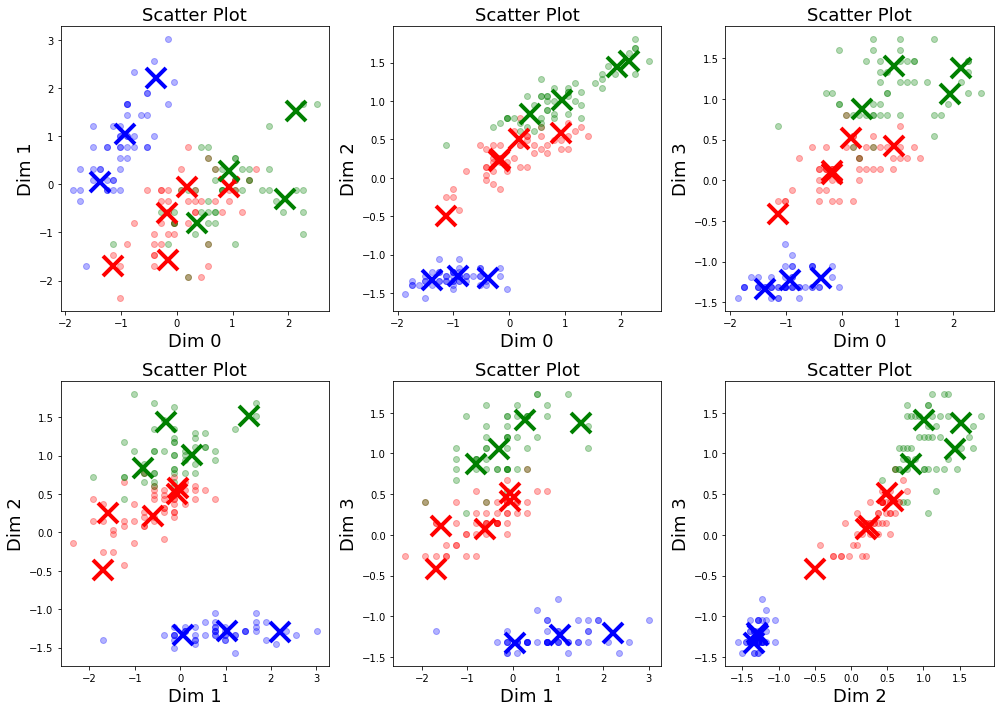

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

m_colors = ['b','r','g']
font_size = 18

trainId,testId = list(foldshandler.split(data,trgt))[0]
data_scaler = StandardScaler().fit(data.values[trainId])
data_norm = data_scaler.transform(data)

nclusters = 12
nclasses = np.unique(trgt).shape[0]

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data_norm)
predicted_data = kmeans.predict(data_norm[trainId])
predicted_classes = np.unique(predicted_data)

# painting clusters
mat_cluster_class = np.zeros([nclasses,nclusters])
for iclass in range(nclasses):
    for iclus in range(nclusters):
        mat_cluster_class[iclass,iclus] = 100.*(float(sum(predicted_data[trgt[trainId]==iclass]==iclus))
                                                 /float(sum(trgt[trainId]==iclass)))
# choose most prob class in each cluster
mop_class = np.argmax(mat_cluster_class,axis=0)


fig = plt.figure(figsize=(14,10))

for idim in range(data.shape[1]-1):
    for jdim in range(idim+1,data.shape[1]):
        #print('idim:',idim, ' jdim:',jdim)
        if idim < 2:
            ax = plt.subplot(2, 3, ((2*idim+jdim)))
        else:
            ax = plt.subplot(2, 3, ((idim+jdim+1)))
        for iclass in range(nclasses):
            ax.plot(data_norm[trgt==iclass,idim],data_norm[trgt==iclass,jdim],
                    'o',alpha=0.3,color=m_colors[iclass])
        for iclus in range(nclusters):
            ax.plot(kmeans.cluster_centers_[iclus][idim],
                    kmeans.cluster_centers_[iclus][jdim],
                    'x',markeredgecolor=m_colors[mop_class[iclus]],
                    markersize=20,mew=4)
            
        ax.set_title('Scatter Plot', fontsize=font_size)
        ax.set_xlabel('Dim %i'%(idim),fontsize=font_size)
        ax.set_ylabel('Dim %i'%(jdim),fontsize=font_size)
plt.tight_layout()

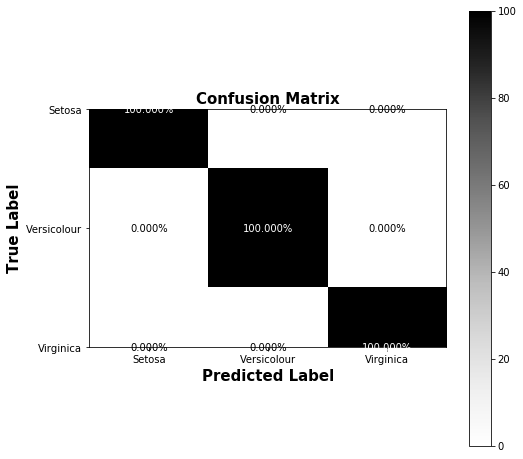

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

m_labels = ['Setosa', 'Versicolour', 'Virginica']
m_colors = ['b','r','g']
font_size = 18

trainId,testId = list(foldshandler.split(data,trgt))[0]
data_scaler = StandardScaler().fit(data.values[trainId])
data_norm = data_scaler.transform(data)

nclusters = 12
nclasses = np.unique(trgt).shape[0]

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data_norm[trainId])
preditions = kmeans.predict(data_norm)

# painting clusters
mat_cluster_class = np.zeros([nclasses,nclusters])
for iclass in range(nclasses):
    for iclus in range(nclusters):
        mat_cluster_class[iclass,iclus] = 100.*(float(sum(preditions[trgt==iclass]==iclus))
                                                 /float(sum(trgt[trainId]==iclass)))
# choose most prob class in each cluster
mop_class = np.argmax(mat_cluster_class,axis=0)

predicted_classes = mop_class[preditions]


cm = confusion_matrix(trgt[testId], predicted_classes[testId])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape

for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);
